# 1. Install Dependencies and Setup

In [1]:
!pip install tensorflow opencv-python matplotlib

In [2]:
!pip list

Package                           Version
--------------------------------- ------------
absl-py                           2.1.0
aiobotocore                       2.7.0
aiohttp                           3.9.3
aioitertools                      0.7.1
aiosignal                         1.2.0
alabaster                         0.7.12
altair                            5.0.1
anaconda-anon-usage               0.4.3
anaconda-catalogs                 0.2.0
anaconda-client                   1.12.3
anaconda-cloud-auth               0.1.4
anaconda-navigator                2.5.3
anaconda-project                  0.11.1
anyio                             4.2.0
appdirs                           1.4.4
applaunchservices                 0.3.0
appnope                           0.1.2
appscript                         1.1.2
archspec                          0.2.1
argon2-cffi                       21.3.0
argon2-cffi-bindings              21.2.0
arrow                             1.2.3
astroid                   

In [3]:
import tensorflow as tf
import os

In [4]:
# Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

In [5]:
tf.config.list_physical_devices('GPU')

[]

# 2. Remove dodgy images

In [10]:
import cv2

In [11]:
data_dir = 'data' 

In [14]:
#image_exts = ['jpeg','jpg', 'bmp', 'png']

In [15]:
# Define the allowed image extensions
image_exts = ['jpg', 'jpeg', 'png', 'bmp', 'svg']  # Add more extensions if needed

for image_class in os.listdir(data_dir):
    image_class_path = os.path.join(data_dir, image_class)
    
    # Check if image_class_path is a directory
    if not os.path.isdir(image_class_path):
        continue
    
    for image in os.listdir(image_class_path):
        image_path = os.path.join(image_class_path, image)
        try:
            # Get the file extension
            ext = image.split('.')[-1].lower()
            
            # Check if the file extension is in the allowed image extension list
            if ext not in image_exts:
                print('Image not in ext list {}'.format(image_path))
                os.remove(image_path)  # Remove the file if it's not in the extension list
            else:
                # Optional: Add imghdr check for validation, but don't rely solely on it
                tip = imghdr.what(image_path)
                if tip not in image_exts:
                    print('Image not in ext list (imghdr check) {}'.format(image_path))
                    os.remove(image_path)
        except Exception as e:
            print('Issue with image {}'.format(image_path))
            # Optionally, remove problematic images
            # os.remove(image_path)

Image not in ext list data/algae/D1u9i8xwvu-2048.webp


# 3. Load Data

In [16]:
import numpy as np
from matplotlib import pyplot as plt

In [17]:
data = tf.keras.utils.image_dataset_from_directory('data')

Found 224 files belonging to 2 classes.


In [18]:
data_iterator = data.as_numpy_iterator()

In [19]:
batch = data_iterator.next()

2024-10-20 13:58:57.831412: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: eXIf: duplicate


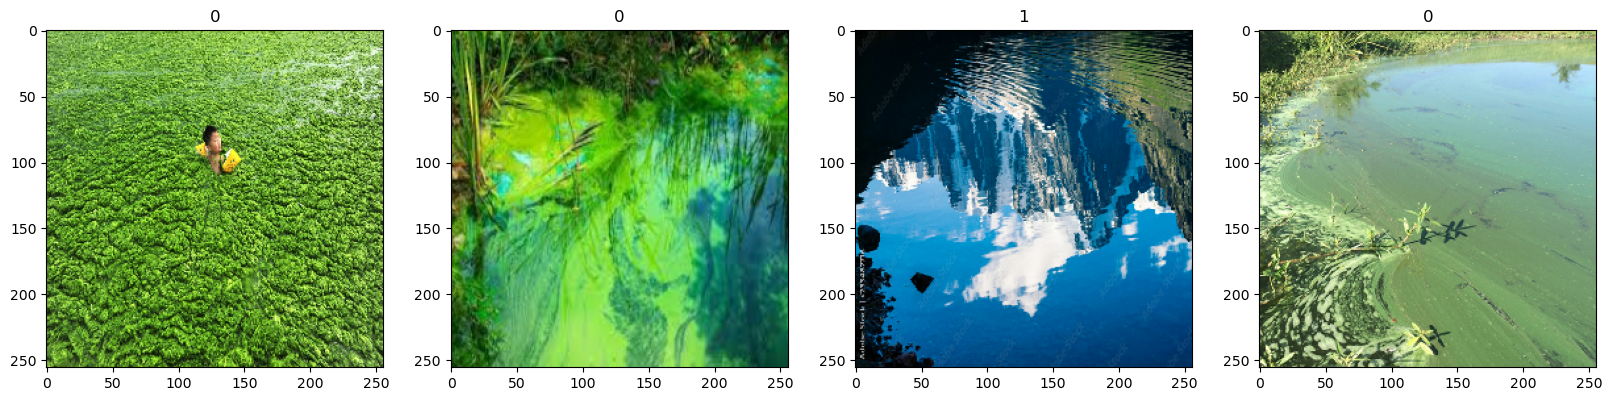

In [20]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

# 4. Scale Data

In [21]:
data = data.map(lambda x,y: (x/255, y))

In [22]:
data.as_numpy_iterator().next()

2024-10-20 14:03:35.386342: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: eXIf: duplicate


(array([[[[0.12439492, 0.14331108, 0.12887062],
          [0.15253392, 0.14976124, 0.10813954],
          [0.14261277, 0.14014848, 0.1050152 ],
          ...,
          [0.18518925, 0.18233398, 0.1559573 ],
          [0.16472021, 0.17190465, 0.1516381 ],
          [0.1596151 , 0.18244985, 0.15338542]],
 
         [[0.120151  , 0.12846868, 0.10339975],
          [0.17785867, 0.1599665 , 0.11356638],
          [0.21691176, 0.19356017, 0.15086715],
          ...,
          [0.24539675, 0.23750931, 0.20788144],
          [0.19401906, 0.20301974, 0.17838739],
          [0.1867797 , 0.21604691, 0.18625186]],
 
         [[0.131281  , 0.13737781, 0.10709289],
          [0.24397212, 0.21609823, 0.17575225],
          [0.27534288, 0.24397032, 0.19333753],
          ...,
          [0.22176833, 0.22629206, 0.20342901],
          [0.20345327, 0.2254262 , 0.20761994],
          [0.2042852 , 0.24652468, 0.22263327]],
 
         ...,
 
         [[0.07439856, 0.15590133, 0.17522576],
          [0.10899

# 5. Split Data

In [39]:
train_size = int(len(data)*.7)
val_size = int(len(data)*.2)
test_size = int(len(data)*.1)

In [24]:
train_size

4

In [25]:
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size+val_size).take(test_size)

# 6. Build Deep Learning Model

In [26]:
train

<_TakeDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [27]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout

In [32]:
model = Sequential()
input_shape=(256,256,3)

In [33]:
model.add(Conv2D(16, (3,3), 1, activation='relu')) 
model.add(MaxPooling2D())
model.add(Conv2D(32, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())
model.add(Conv2D(16, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [34]:
model.compile('adam', loss=tf.losses.BinaryCrossentropy(), metrics=['accuracy'])

In [35]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

# 7. Train

In [36]:
logdir='logs'

In [37]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [38]:
hist = model.fit(train, epochs=20, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/20


2024-10-20 14:09:34.916499: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: eXIf: duplicate


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step - accuracy: 0.5404 - loss: 0.8810

2024-10-20 14:09:36.706290: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: eXIf: duplicate


4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 463ms/step - accuracy: 0.5260 - loss: 0.8811 - val_accuracy: 0.8438 - val_loss: 0.5703
Epoch 2/20


2024-10-20 14:09:37.436695: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: eXIf: duplicate


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step - accuracy: 0.7702 - loss: 0.5505

2024-10-20 14:09:38.959897: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: eXIf: duplicate


4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 447ms/step - accuracy: 0.7646 - loss: 0.5468 - val_accuracy: 0.9062 - val_loss: 0.2995
Epoch 3/20


2024-10-20 14:09:39.675564: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: eXIf: duplicate


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step - accuracy: 0.8991 - loss: 0.3542

2024-10-20 14:09:41.149378: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: eXIf: duplicate


4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 434ms/step - accuracy: 0.8927 - loss: 0.3572 - val_accuracy: 0.9062 - val_loss: 0.3322
Epoch 4/20


2024-10-20 14:09:41.875912: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: eXIf: duplicate


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step - accuracy: 0.8138 - loss: 0.4004

2024-10-20 14:09:43.337956: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: eXIf: duplicate


4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 439ms/step - accuracy: 0.8104 - loss: 0.4007 - val_accuracy: 0.8750 - val_loss: 0.2588
Epoch 5/20


2024-10-20 14:09:44.058651: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: eXIf: duplicate


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step - accuracy: 0.8997 - loss: 0.2760

2024-10-20 14:09:45.524915: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: eXIf: duplicate


4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 432ms/step - accuracy: 0.9010 - loss: 0.2760 - val_accuracy: 0.9375 - val_loss: 0.2844
Epoch 6/20


2024-10-20 14:09:46.231797: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: eXIf: duplicate


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step - accuracy: 0.9173 - loss: 0.1970

2024-10-20 14:09:47.649321: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: eXIf: duplicate


4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 428ms/step - accuracy: 0.9198 - loss: 0.1983 - val_accuracy: 0.9688 - val_loss: 0.1589
Epoch 7/20


2024-10-20 14:09:48.372097: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: eXIf: duplicate


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step - accuracy: 0.9492 - loss: 0.1875

2024-10-20 14:09:49.824765: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: eXIf: duplicate


4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 437ms/step - accuracy: 0.9469 - loss: 0.1896 - val_accuracy: 0.9688 - val_loss: 0.1503
Epoch 8/20


2024-10-20 14:09:50.550770: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: eXIf: duplicate


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step - accuracy: 0.9655 - loss: 0.1219

2024-10-20 14:09:52.005319: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: eXIf: duplicate


4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 441ms/step - accuracy: 0.9677 - loss: 0.1185 - val_accuracy: 1.0000 - val_loss: 0.0650
Epoch 9/20


2024-10-20 14:09:52.768359: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: eXIf: duplicate


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step - accuracy: 0.9668 - loss: 0.1103

2024-10-20 14:09:54.243278: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: eXIf: duplicate


4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 430ms/step - accuracy: 0.9656 - loss: 0.1097 - val_accuracy: 0.9375 - val_loss: 0.1398
Epoch 10/20


2024-10-20 14:09:54.950656: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: eXIf: duplicate


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step - accuracy: 0.9733 - loss: 0.0841

2024-10-20 14:09:56.376787: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: eXIf: duplicate


4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 423ms/step - accuracy: 0.9708 - loss: 0.0866 - val_accuracy: 0.9688 - val_loss: 0.0934
Epoch 11/20


2024-10-20 14:09:57.100591: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: eXIf: duplicate


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step - accuracy: 0.9616 - loss: 0.1192

2024-10-20 14:09:58.526569: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: eXIf: duplicate


4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 424ms/step - accuracy: 0.9615 - loss: 0.1186 - val_accuracy: 0.9375 - val_loss: 0.1219
Epoch 12/20


2024-10-20 14:09:59.238236: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: eXIf: duplicate


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step - accuracy: 0.9811 - loss: 0.0583

2024-10-20 14:10:00.661402: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: eXIf: duplicate


4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 422ms/step - accuracy: 0.9802 - loss: 0.0599 - val_accuracy: 1.0000 - val_loss: 0.0595
Epoch 13/20


2024-10-20 14:10:01.368077: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: eXIf: duplicate


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step - accuracy: 0.9792 - loss: 0.0875

2024-10-20 14:10:02.757157: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: eXIf: duplicate


4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 419ms/step - accuracy: 0.9802 - loss: 0.0829 - val_accuracy: 0.9688 - val_loss: 0.0497
Epoch 14/20


2024-10-20 14:10:03.468755: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: eXIf: duplicate


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step - accuracy: 0.9766 - loss: 0.0831

2024-10-20 14:10:04.886486: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: eXIf: duplicate


4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 422ms/step - accuracy: 0.9750 - loss: 0.0900 - val_accuracy: 0.9688 - val_loss: 0.0723
Epoch 15/20


2024-10-20 14:10:05.601937: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: eXIf: duplicate


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step - accuracy: 0.9616 - loss: 0.0884

2024-10-20 14:10:07.013114: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: eXIf: duplicate


4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 420ms/step - accuracy: 0.9583 - loss: 0.0942 - val_accuracy: 0.9688 - val_loss: 0.0602
Epoch 16/20


2024-10-20 14:10:07.727108: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: eXIf: duplicate


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step - accuracy: 0.9922 - loss: 0.0373

2024-10-20 14:10:09.134597: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: eXIf: duplicate


4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 424ms/step - accuracy: 0.9875 - loss: 0.0459 - val_accuracy: 0.9688 - val_loss: 0.0562
Epoch 17/20


2024-10-20 14:10:09.856747: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: eXIf: duplicate


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step - accuracy: 0.9740 - loss: 0.0805

2024-10-20 14:10:11.260860: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: eXIf: duplicate


4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 422ms/step - accuracy: 0.9729 - loss: 0.0823 - val_accuracy: 1.0000 - val_loss: 0.0170
Epoch 18/20


2024-10-20 14:10:11.988251: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: eXIf: duplicate


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step - accuracy: 0.9544 - loss: 0.0758

2024-10-20 14:10:13.442314: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: eXIf: duplicate


4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 432ms/step - accuracy: 0.9573 - loss: 0.0750 - val_accuracy: 0.9375 - val_loss: 0.1599
Epoch 19/20


2024-10-20 14:10:14.167239: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: eXIf: duplicate


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step - accuracy: 0.9798 - loss: 0.0495

2024-10-20 14:10:15.597062: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: eXIf: duplicate


4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 426ms/step - accuracy: 0.9792 - loss: 0.0504 - val_accuracy: 1.0000 - val_loss: 0.0235
Epoch 20/20


2024-10-20 14:10:16.316301: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: eXIf: duplicate


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step - accuracy: 0.9701 - loss: 0.0860

2024-10-20 14:10:17.753512: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: eXIf: duplicate


4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 433ms/step - accuracy: 0.9698 - loss: 0.0877 - val_accuracy: 0.9688 - val_loss: 0.0398


# 8. Plot Performance

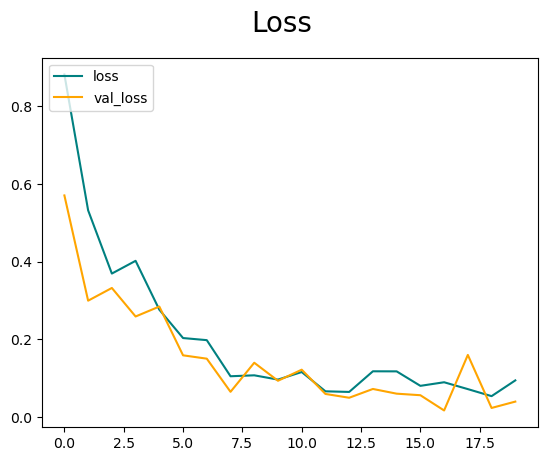

In [40]:
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

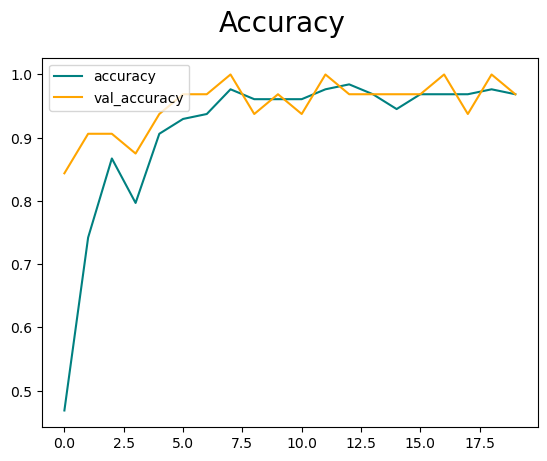

In [41]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

# 9. Evaluate

In [42]:
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy

In [43]:
pre = Precision()
re = Recall()
acc = BinaryAccuracy()

In [44]:
for batch in test.as_numpy_iterator(): 
    X, y = batch
    yhat = model.predict(X)
    pre.update_state(y, yhat)
    re.update_state(y, yhat)
    acc.update_state(y, yhat)

2024-10-20 14:15:46.752919: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [45]:
print(pre.result(), re.result(), acc.result())

tf.Tensor(0.0, shape=(), dtype=float32) tf.Tensor(0.0, shape=(), dtype=float32) tf.Tensor(0.0, shape=(), dtype=float32)


# 10. Test

In [46]:
import cv2

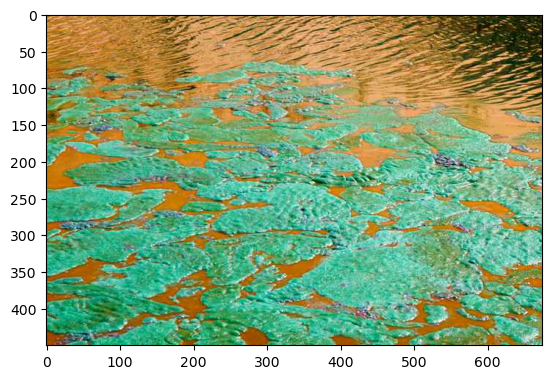

In [48]:
img = cv2.imread('/Users/pete/Documents/GitHub/ImageClassification/data/algae/1_11zon.jpg')
plt.imshow(img)
plt.show()

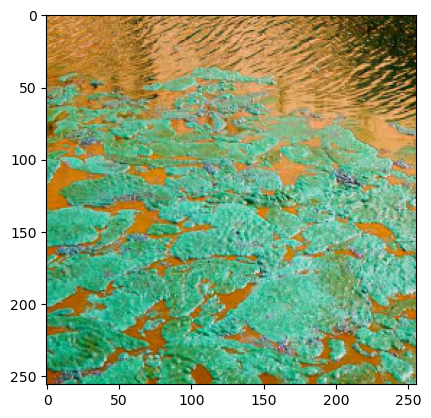

In [49]:
resize = tf.image.resize(img, (256,256))
plt.imshow(resize.numpy().astype(int))
plt.show()

In [50]:
yhat = model.predict(np.expand_dims(resize/255, 0))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


In [51]:
yhat

array([[0.09803825]], dtype=float32)

In [52]:
if yhat > 0.5: 
    print(f'Predicted class is Water')
else:
    print(f'Predicted class is Algae')

Predicted class is Happy


# 11. Save the Model

In [54]:
from tensorflow.keras.models import load_model

In [55]:
model.save(os.path.join('models','imageclassifier.h5'))

In [57]:
new_model = load_model('/Users/pete/Documents/GitHub/ImageClassification/models/imageclassifier.h5')

In [58]:
new_model.predict(np.expand_dims(resize/255, 0))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


array([[0.09803825]], dtype=float32)